In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

### Load MNIST dataset

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
num_train = mnist.train.num_examples 
num_validation = mnist.validation.num_examples
num_test = mnist.test.num_examples 
print(num_train, num_validation, num_test)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
55000 5000 10000


# Part a: Define and implement computation graph

Set parameters.

In [26]:
lr = 0.01
batch_size = 128
n_hidden_1 = 300
num_input = 784
num_classes = 10
layers_dims = [num_input, n_hidden_1, num_classes]

Initialization.

In [27]:
def initialize(layers_dims):
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.normal(0,1,(layers_dims[l - 1],layers_dims[l]))
        parameters["b" + str(l)] = np.zeros((1,layers_dims[l]))

        #print(parameters["W" + str(l)].shape)
        assert parameters["W" + str(l)].shape == (
             layers_dims[l - 1],layers_dims[l])
        assert parameters["b" + str(l)].shape == (1,layers_dims[l])
    
    return parameters

Define layers.

In [28]:
def relu(Z):
    A = np.maximum(0, Z)
    return A, Z

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [29]:
def linear(A_prev, W, b):
    Z = np.dot(A_prev, W) + b
    cache = (A_prev, W, b)
    return Z, cache

In [30]:
def linear_activation(A_prev, W, b, activation_fn):
    assert activation_fn == "sigmoid" or activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (A_prev.shape[0], W.shape[1])

    cache = (linear_cache, activation_cache)
    return A, cache

In [31]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #print( np.sum(np.exp(x), axis=1).shape)
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

Define cost function.

In [32]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions))/N
    return ce

Define inputs.

In [33]:
input_x, input_y = mnist.train.next_batch(batch_size, shuffle=False)
print('x.shape:', input_x.shape)
print('y.shape:', input_y.shape)

x.shape: (128, 784)
y.shape: (128, 10)


# Part b: Implement forward propagation

In [34]:
parameters = initialize(layers_dims)

In [35]:
hidden_x, cache_1 = linear_activation(input_x, parameters['W1'], parameters['b1'], "relu")
output_x, cache_2 = linear_activation(hidden_x, parameters['W2'], parameters['b2'], "sigmoid")
output_y = softmax(output_x)
cost = cross_entropy(output_y,input_y)
print('The cost is: ', cost)

The cost is:  2.479740765431488


# Part c: Compute gradients of cost function

In [36]:
dL = - np.divide(input_y, output_y) + np.divide(1 - input_y, 1 - output_y)

# Part d: Implement back-propagation

In [37]:
def sigmoid_gradient(dA, Z):
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)
    return dZ

In [38]:
def relu_gradient(dA, Z):
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))
    return dZ

In [39]:
def linear_back(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[0]
    
    dW = (1 / m) * np.dot(A_prev.T, dZ)
    db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, W.T) 

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db

In [40]:
def linear_activation_back(dA, cache, activation_fn):
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_back(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_back(dZ, linear_cache)

    return dA_prev, dW, db

In [41]:
grads = {}
grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_back(dL, cache_2, "sigmoid")
grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_back(grads["dA2"], cache_1, "relu")

In [42]:
def back_propagate(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

# Part e: Plot and show results

In [43]:
batch_size_list = [16,64,256,1024]
num_iter = 10000

In [44]:
def forward(X, params):
    hidden_x, cache_1 = linear_activation(X, parameters['W1'], parameters['b1'],"relu")
    output_x, cache_2 = linear_activation(hidden_x, parameters['W2'], parameters['b2'],"sigmoid")
    output_y = softmax(output_x)
    return output_y, cache_1, cache_2

In [45]:
def accuracy(y_pred, y):
    predict = np.argmax(y_pred, axis=1)
    labels = np.argmax(y, axis=1)
    accuracy = np.mean(labels == predict) * 100
    return accuracy

/home/yzwang/Courses/EE596B/venv/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


batch size: 16, accuracy: 73.87, training time 15.4778 seconds
batch size: 64, accuracy: 77.90, training time 31.4528 seconds
batch size: 256, accuracy: 76.23, training time 75.8562 seconds
batch size: 1024, accuracy: 75.60, training time 221.8101 seconds


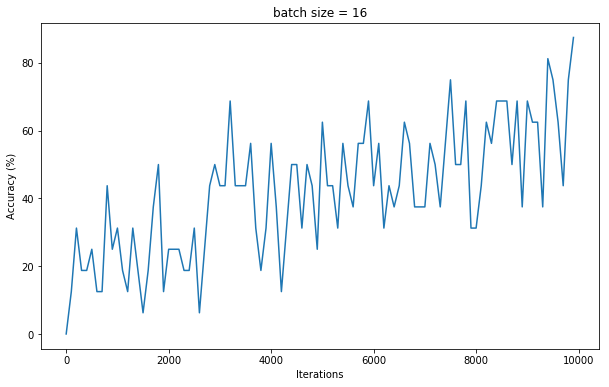

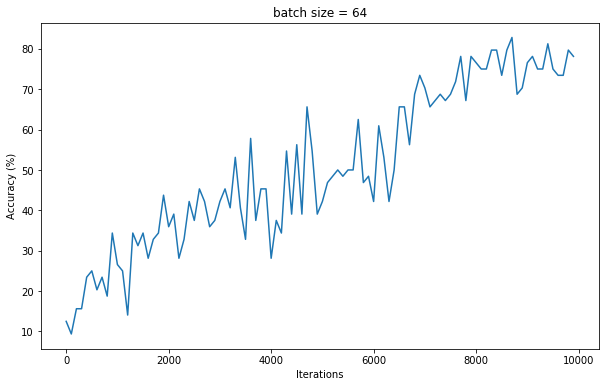

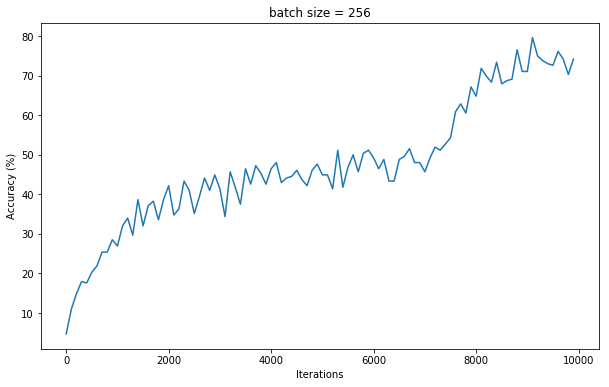

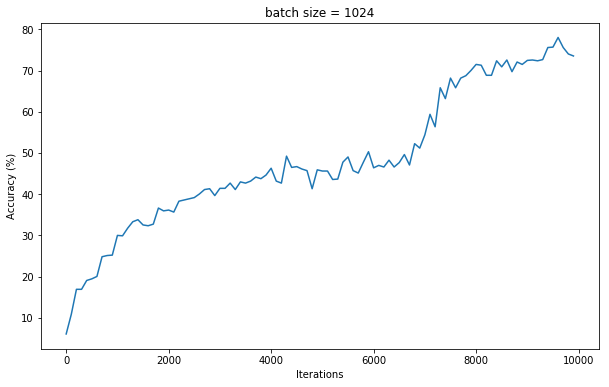

In [46]:
for j in range(len(batch_size_list)):
    batch_size = batch_size_list[j]
    acc_list = []
    grads = {}
    parameters = initialize(layers_dims)
    start_time = time.time()
    for i in range(num_iter):
        input_x, input_y = mnist.train.next_batch(batch_size)
        output_y, cache_1, cache_2 = forward(input_x, parameters)
        acc = accuracy(output_y, input_y)
        cost = cross_entropy(output_y,input_y)
        dL = - (np.divide(input_y, output_y) - np.divide(1 - input_y, 1 - output_y));

        grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_back(dL, cache_2, "sigmoid")
        grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_back(grads["dA2"], cache_1, "relu")

        # update parameters
        parameters = back_propagate(parameters, grads, lr)

        # append each 100th cost to the cost list
        #if (i + 1) % 100 == 0:
         #   print("The cost after",i+1,"iterations is:",cost)
        if i % 100 == 0:
            acc_list.append(acc)
    use_time = time.time() - start_time
    output_y, _, _ = forward(mnist.test.images, parameters)
    accu = accuracy(output_y, mnist.test.labels)
    print("batch size: %d, accuracy: %.2f, training time %.4f seconds" % (batch_size, accu, use_time))
    
    # plot the cost curve
    plt.figure(j, figsize=(10, 6))
    plt.plot(np.arange(len(acc_list))*100, acc_list)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("batch size = %d" % batch_size)

# Part f: Implement Adam Optimizer

In [47]:
def back_propagate_adam(parameters, grads, lr, t, vs, sqrs):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    for index in parameters:
        param = parameters[index]
        grad = grads["d" + index]
        v = vs[index]
        sqr = sqrs[index]
        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * np.square(grad)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        div = lr * v_bias_corr / (np.sqrt(sqr_bias_corr) + eps_stable)
        param[:] = param - div
    
    return parameters, vs, sqrs

In [48]:
def initialize_adam(parameters):
    vs = {}
    sqrs = {}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        vs["W" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        vs["b" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        sqrs["W" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        sqrs["b" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    return vs, sqrs

/home/yzwang/Courses/EE596B/venv/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


batch size: 16, accuracy: 37.53, training time 50.3649 seconds
batch size: 64, accuracy: 73.33, training time 53.7631 seconds
batch size: 256, accuracy: 94.56, training time 89.4142 seconds
batch size: 1024, accuracy: 97.25, training time 234.5770 seconds


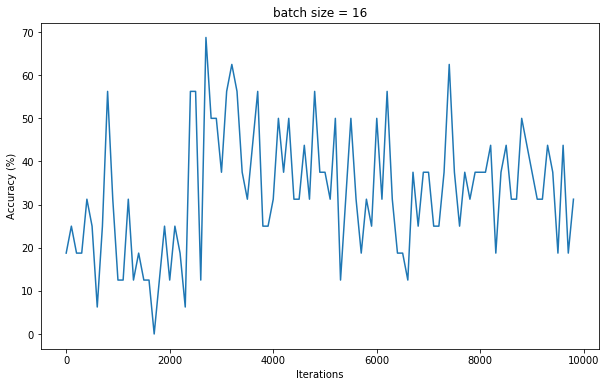

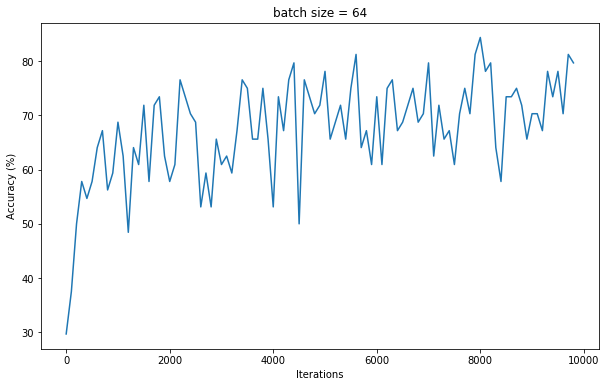

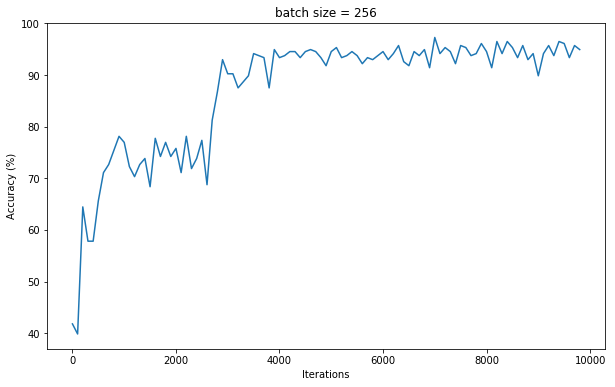

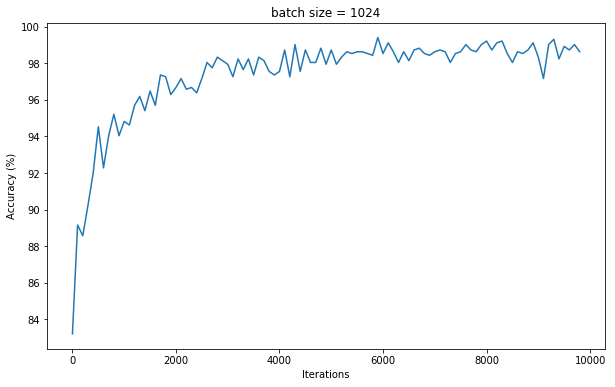

In [50]:
for j in range(len(batch_size_list)):
    batch_size = batch_size_list[j]
    acc_list = []
    grads = {}
    parameters = initialize(layers_dims)

    vs, sqrs = initialize_adam(parameters)
    start_time = time.time()
    
    for i in range(1, num_iter):
        input_x, input_y = mnist.train.next_batch(batch_size)
        output_y, cache_1, cache_2 = forward(input_x, parameters)
        acc = accuracy(output_y, input_y)
        cost = cross_entropy(output_y,input_y)
        dL = - (np.divide(input_y, output_y) - np.divide(1 - input_y, 1 - output_y));

        grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_back(dL, cache_2, "sigmoid")
        grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_back(grads["dA2"], cache_1, "relu")

        # update parameters
        parameters, vs, sqrs = back_propagate_adam(parameters, grads, lr, i, vs, sqrs)

        # append each 100th cost to the cost list
        if i % 100 == 0:
            acc_list.append(acc)
    
    use_time = time.time() - start_time
    output_y, _, _ = forward(mnist.test.images, parameters)
    accu = accuracy(output_y, mnist.test.labels)
    print("batch size: %d, accuracy: %.2f, training time %.4f seconds" % (batch_size, accu, use_time))
    
    # plot the cost curve
    plt.figure(j, figsize=(10, 6))
    plt.plot(np.arange(len(acc_list))*100, acc_list)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("batch size = %d" % batch_size)

# Part g: Implement in TensorFlow

batch size: 16, accuracy: 39.04, training time 6.3656 seconds
batch size: 64, accuracy: 33.84, training time 9.6220 seconds
batch size: 256, accuracy: 36.04, training time 12.8077 seconds
batch size: 1024, accuracy: 30.06, training time 39.9010 seconds


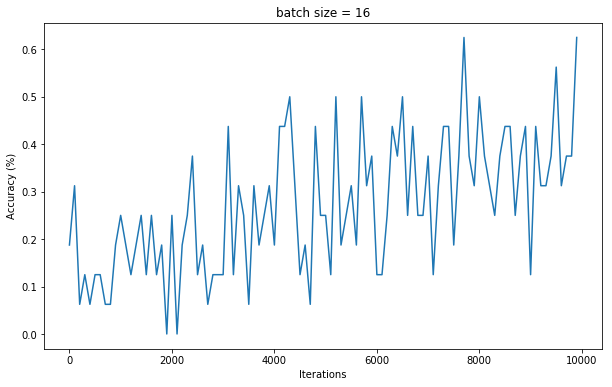

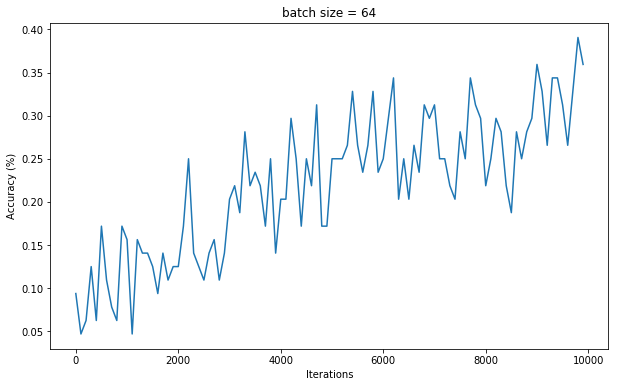

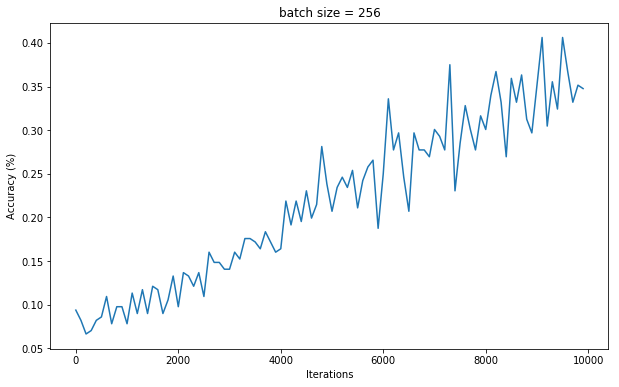

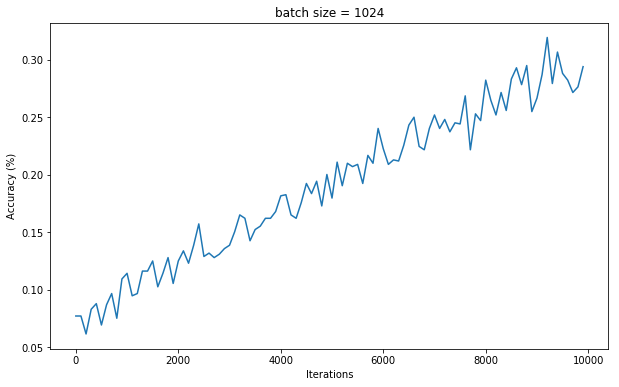

In [54]:
#fixed network parameters
num_input = 784
num_classes = 10
n_hidden_1 = 300

for batch_size in batch_size_list:
    #Define placeholder and Variables
    tf.reset_default_graph()
    #tf graph input
    X = tf.placeholder(tf.float32,[None,num_input],name='X')
    Y = tf.placeholder(tf.float32,[None,num_classes],name='Y')

    #Layers weight & bias
    weights = {
        'W1': tf.Variable(tf.random_normal([num_input, n_hidden_1]),name='W1'),
        'Wout': tf.Variable(tf.random_normal([n_hidden_1, num_classes]),name='Wout')
    }

    biases = {
        'b1': tf.Variable(tf.random_normal(shape=[n_hidden_1]),name='b1'),
        'bout': tf.Variable(tf.random_normal(shape=[num_classes]),name='bout')
    }

    #define nueral network
    def neural_net(x):
        layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
        out = tf.sigmoid(tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout']))
        return out     

    #define cost function and accuracy
    #predicted labels
    logits = neural_net(X)

    #define loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y))

    #define optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)

    #compare the predicted labels with true labels
    correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

    #compute the accuracy by taking average
    accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

    #Initialize the variables
    init = tf.global_variables_initializer()

    acc_list = []
    #execute training
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        for i in range(num_iter):
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
            if i % 100 == 0:
                acc_list.append(sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y}))


        use_time = time.time() - start_time
        accu = sess.run(accuracy,feed_dict={X:mnist.test.images, Y:mnist.test.labels})*100
        print("batch size: %d, accuracy: %.2f, training time %.4f seconds" % (batch_size, accu, use_time))

        # plot the cost curve
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(acc_list))*100, acc_list)
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy (%)")
        plt.title("batch size = %d" % batch_size)

batch size: 16, accuracy: 50.88, training time 7.0191 seconds
batch size: 64, accuracy: 69.67, training time 9.9818 seconds
batch size: 256, accuracy: 94.27, training time 13.3851 seconds
batch size: 1024, accuracy: 87.70, training time 35.9419 seconds


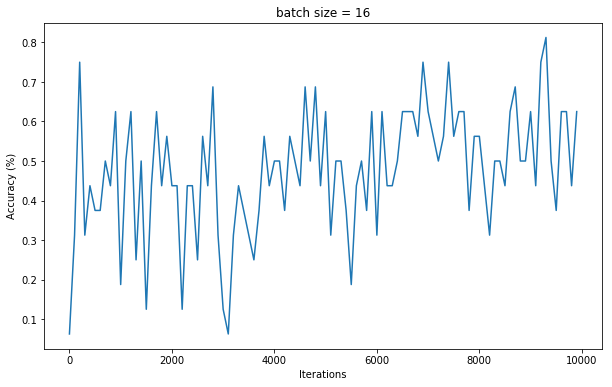

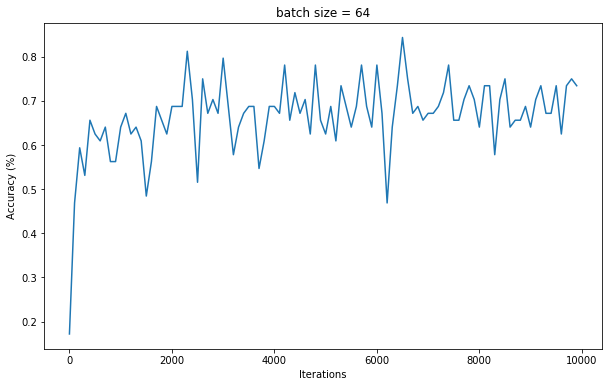

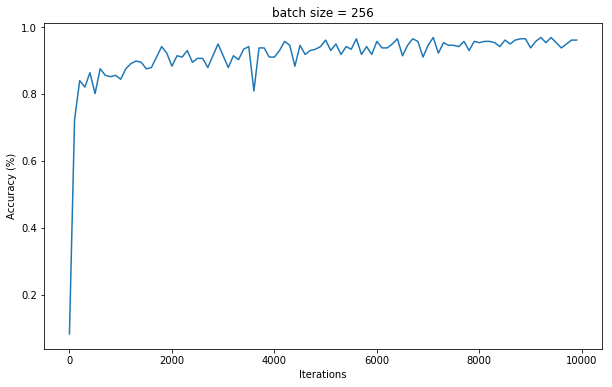

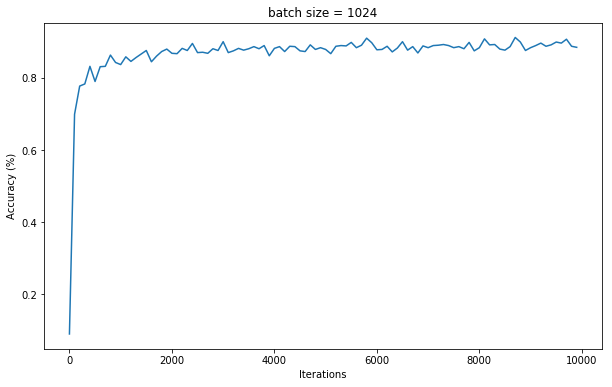

In [55]:
#fixed network parameters
num_input = 784
num_classes = 10
n_hidden_1 = 300

for batch_size in batch_size_list:
    #Define placeholder and Variables
    tf.reset_default_graph()
    #tf graph input
    X = tf.placeholder(tf.float32,[None,num_input],name='X')
    Y = tf.placeholder(tf.float32,[None,num_classes],name='Y')

    #Layers weight & bias
    weights = {
        'W1': tf.Variable(tf.random_normal([num_input, n_hidden_1]),name='W1'),
        'Wout': tf.Variable(tf.random_normal([n_hidden_1, num_classes]),name='Wout')
    }

    biases = {
        'b1': tf.Variable(tf.random_normal(shape=[n_hidden_1]),name='b1'),
        'bout': tf.Variable(tf.random_normal(shape=[num_classes]),name='bout')
    }

    #define nueral network
    def neural_net(x):
        layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
        out = tf.sigmoid(tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout']))
        return out     

    #define cost function and accuracy
    #predicted labels
    logits = neural_net(X)

    #define loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y))

    #define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)

    #compare the predicted labels with true labels
    correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

    #compute the accuracy by taking average
    accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

    #Initialize the variables
    init = tf.global_variables_initializer()

    acc_list = []
    #execute training
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        for i in range(num_iter):
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
            if i % 100 == 0:
                acc_list.append(sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y}))


        use_time = time.time() - start_time
        accu = sess.run(accuracy,feed_dict={X:mnist.test.images, Y:mnist.test.labels})*100
        print("batch size: %d, accuracy: %.2f, training time %.4f seconds" % (batch_size, accu, use_time))

        # plot the cost curve
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(acc_list))*100, acc_list)
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy (%)")
        plt.title("batch size = %d" % batch_size)

For comparison, two kinds of code obtain similar results when using the same optimizer. 